# FIXME

1. [x] Clean up the file
  - [x] Clean up the imports
  - [x] Clean up the helper functions - ultimately these should use the libraries
  - [x] Clean up the plots
2. [ ] Figure out exactly which variables need to be swept over
  - [ ] The required variables are apr, time, and the percent of the bond ratio.
  - [ ] Are share price and initial share price essential? What we can do is start without them and see how bad the approximation is with non-trivial values.
3. [ ] Write the sweeping logic and sanity check it
4. [ ] Write the naive interpolation logic
5. [ ] Measure the error for random points on the interpolation space
6. [ ] Attempt to develop a better approximation using the methods from Remco's blogpost
7. [ ] Ensure that our approximation never overshoots. This is currently a problem, which will given inaccurate results.

# Methods

We desire an approximation for the maximum amount of bonds that a trader can short given the ratio of their cash balance to the AMMs cash reserve. To do this, we can calculate the maximum loss for short positions opened with a range of APRs, time remaining, and ratios of bonds to the total bond reserves. For a fixed APR and time remaining, we'll have an array of the maximum loss and the bond ratios shorted. We can find an approximation that tightly fits these points, which is a function of a max loss in base that outputs the ratio of bonds required to hit the max loss.

## TODO - Add detail about the interpolation.

In [358]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg.special_matrices import math
from scipy.optimize import curve_fit
import scipy

In [359]:
def calc_k_const(share_reserves, bond_reserves, share_price, init_share_price, time_remaining):
    """Returns the 'k' constant variable for trade mathematics"""
    scale = share_price / init_share_price
    return scale * (init_share_price * share_reserves) ** (1 - time_remaining) + (bond_reserves) ** (
        1 - time_remaining
    )

def calc_bond_reserves(share_reserves, apr, share_price, init_share_price, time_remaining):
    """Calculates the bond reserves from the share reserves and a target apr"""
    return (init_share_price * share_reserves) * (1 + apr * time_remaining) ** (1 / time_remaining)

# FIXME: This doesn't incorporate fees
def calc_max_loss(share_reserves, bond_reserves, d_bonds, share_price, init_share_price, time_remaining):
    k = calc_k_const(share_reserves, bond_reserves, share_price, init_share_price, time_remaining)
    d_shares = share_reserves - (1 / init_share_price) * ((init_share_price / share_price) * (k - (bond_reserves + d_bonds) ** (1 - time_remaining))) ** (1 / (1 - time_remaining))
    return d_bonds - d_shares

def calc_max_loss_from_apr(share_reserves, bond_percentage, apr, share_price, init_share_price, time_remaining):
    bond_reserves = calc_bond_reserves(share_reserves, apr, share_price, init_share_price, time_remaining)
    d_bonds = bond_reserves * bond_percentage
    return calc_max_loss(share_reserves, bond_reserves, d_bonds, share_price, init_share_price, time_remaining)

# FIXME: Comment this
# FIXME: Is there a cleaner way to accomplish this using numpy?
def calc_chebyshev_nodes(start, end, num_points):
    i = np.delete(np.arange(num_points + 1), 0)
    return ((start + end) / 2) + ((end - start) / 2) * np.cos(((2 * i + 1) / (2 * num_points)) * np.pi)

# FIXME: Implement polynomial interpolation
def interpolate_polynomial(xp, yp, num_parameters):
    a = np.vander(xp, num_parameters, True)
    params = np.linalg.solve(a, yp)
    return np.polynomial.Polynomial(params)

# FIXME: Implmenet Remez's algorithm for polynomials

# FIXME: Implement rational interpolation

# FIXME: Implement Remez's algorithm for rationals



# FIXME: Implement general rational curve fitting function using scipy.optimize.curvefit
# FIXME: Document this. 
# FIXME: Try to optimize this using the dot product of the parameter list and vandermonde matrices
def ratfit(xdata, ydata, xtest, ytest, max_degree):
    """Finds the rational polynomial that minimizes the maximum error up to the given degree"""
    def ratobj(num_degree):
        return lambda x, *coeffs: np.polyval(coeffs[:num_degree], x) / (1 + np.polyval(coeffs[num_degree:], x) * x)
    min_error = float("inf")
    min_num_degree = 1
    min_popt = np.ones(1)
    # Compute the least squares optimal rational polynomial over all of the possible degrees
    for degree in range(2, max_degree + 1):
        for div_degree in range(0, degree):
            num_degree = degree - div_degree
            print(f"num_degree = {num_degree} & div_degree = {div_degree}")
            try: 
                # Compute the optimal parameters
                p0 = tuple(np.ones(degree))
                popt, _ = scipy.optimize.curve_fit(ratobj(num_degree), xdata, ydata, p0=p0)
                # Compute the error and the maximum error with the objective function
                error = ytest - ratobj(num_degree)(xtest, *popt)
                error = max(np.amax(error), np.abs(np.amin(error)))
                print(f"error = {error} & min_error = {min_error}")
                if error < min_error:
                    print(f"updated best fit")
                    min_error = error
                    min_num_degree = num_degree
                    min_popt = popt
            except RuntimeError as e:
                print(f"ratfit: curve fitting failed for ({num_degree}, {div_degree}) rational with: {e}")
    return lambda x: ratobj(min_num_degree)(x, *min_popt)

In [360]:
# FIXME: We may not need to sweep over c, mu, and z.
# Simulation Variables
c = 1           # share price
mu = 1          # init share price
z = 10**6       # share reserves -- this is arbitrary for this analysis
apr = 0.02      # apr
t = 0.5         # time remaining
y_percent = 0.1 # percent of bond reserves to be shorted

# Other Variables
interpolation_points = 100
verbose = False

In [361]:
# FIXME: This will ultimately be where the sweep code lives.
# FIXME: We should be able to start at zero. We may need to add a constant term
#        to the log.
 
# Capture an array of max losses (the x component) and the bond ratios (the y component) 
# that require the max losses.

# FIXME: This isn't working correctly
y = calc_chebyshev_nodes(0, 100, interpolation_points)
x = (calc_max_loss_from_apr(z, 0.1 * y, apr, c, mu, t) / z) * 100
if verbose:
    print(
        f"max loss = {x}"
        f"\nbond percentages = {y}"
    )

Text(0, 0.5, 'Bond Percent')

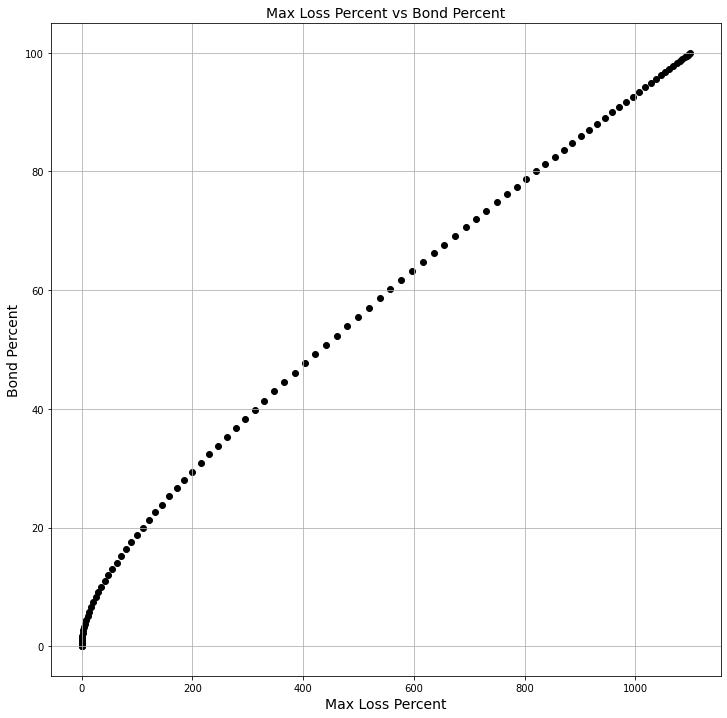

In [362]:
# Plot the raw data output by the sweep
plt.subplots(figsize=(12,12))
plt.scatter(x,y,color='black')
plt.grid(True)
plt.title('Max Loss Percent vs Bond Percent', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Bond Percent', fontsize=14)

In [363]:
# FIXME: Using higher order functions, I should be able to write a function that
# selects the optimal rational curves of a given degree
#
# FIXME: Rational approximation
# 
# - (2, 2) worked well 
# - (3, 3) worked better 
# - 4 is bad 
# - (4, 5) is great 
# - (6, 5) is amazing (up to x**6 on top and up to x**5 on bottom):
#    - median error = 0.00007141856130488122
#.   - average error = 0.00002661035303862281
#.   - min error = -0.00567110813004922942
#.   - max error = 0.00549624925446562385
#def rational_objective(xp, p_1, p_2, p_3, p_4, p_5, p_6, p_7, p_8, p_9, p_10, p_11, p_12):
#    return (p_1 + p_2 * xp + p_3 * xp ** 2 + p_4 * xp ** 3 + p_5 * xp ** 4 + p_6 * xp ** 5 + p_7 * xp ** 6) / (1 + p_8 * xp + p_9 * xp ** 2 + p_10 * xp ** 3 + p_11 * xp ** 4 + p_12 * xp ** 5)
#popt, _ = curve_fit(rational_objective, x, y)
#p_1, p_2, p_3, p_4, p_5, p_6, p_7, p_8, p_9, p_10, p_11, p_12 = popt
#print(f"y = ({p_1} + {p_2} * x + {p_3} * x ** 2) / (1 + {p_4} * x + {p_5} * x ** 2)")
#def f_approx(xp):
#    return rational_objective(xp, p_1, p_2, p_3, p_4, p_5, p_6, p_7, p_8, p_9, p_10, p_11, p_12)

# FIXME: Rational Approximation With:
# 
# 2 Terms:
# - (1, 1) sucks
# 
# 3 Terms:
# - (1, 2) sucks
# - (2, 1)
#   - median error = -0.09727479942602457186
#   - average error = 0.16293343246644767519
#   - min error = -3.42980164872685389099
#   - max error = 2.71382462648255895488
# 
# 4 terms
# - (1, 3) sucks
# - (2, 2) 
#   - median error = 0.13064193188453998573
#   - average error = 0.11875403765646180831
#   - min error = -2.02639401665259022423
#   - max error = 1.76407016435736352378
# - (3, 1)
#   - median error = 0.12247205301837915670
#   - average error = 0.07048912471704676941
#   - min error = -1.07646042944339903613
#   - max error = 1.04750982155719096767
#def rational_objective(xp, p_1, p_2, p_3, p_4):
#    return (p_1 + p_2 * xp + p_3 * xp ** 2) / (1 + p_4 * xp)
#popt, _ = curve_fit(rational_objective, x, y)
#p_1, p_2, p_3, p_4 = popt
#print(f"y = ({p_1} + {p_2} * x + {p_3} * x ** 2) / (1 + {p_4} * x + {p_5} * x ** 2)")
#def f_approx(xp):
#    return rational_objective(xp, p_1, p_2, p_3, p_4)

In [364]:
# Polynomial Interpolation
f_approx = interpolate_polynomial(x, y, interpolation_points)

In [365]:
##def polynomial_objective(xp, a, b):
#    return a * xp ** b
#popt, _ = curve_fit(polynomial_objective, x, y)
#a, b = popt
#def f_approx(xp):
#    return polynomial_objective(xp, a, b)

In [366]:
# Construct a new trace of sample data to test for the error
y_test = np.delete(np.arange(0, 100, 0.001), 0)
x_test = (calc_max_loss_from_apr(z, 0.1 * y_test, apr, c, mu, t) / z) * 100

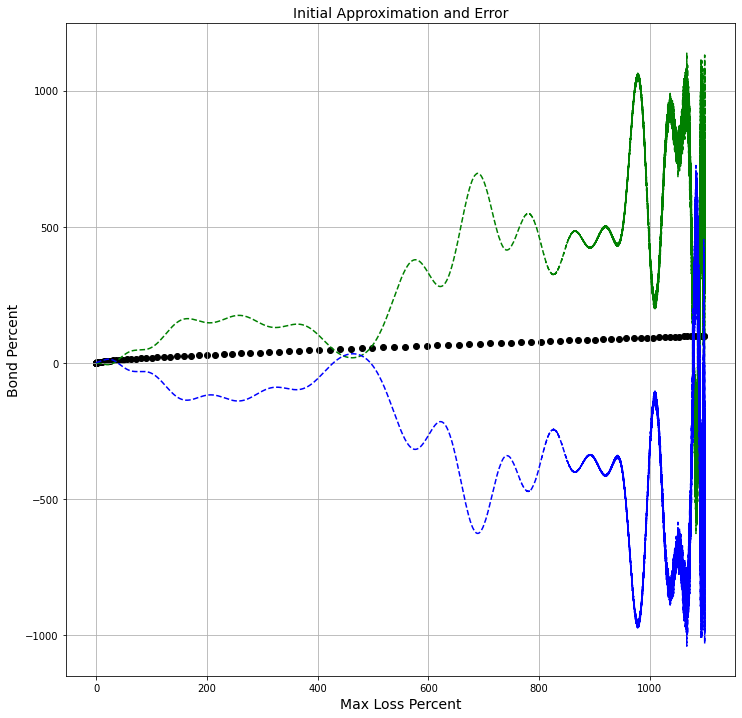

In [367]:
# Plot the Chebyshev approximation against the raw data
plt.subplots(figsize=(12,12))
plt.scatter(x,y,color='black')
# FIXME: It would be good to showcase the fact that we are using different sample data when testing for error.
# plt.scatter(x_test,y_test,color='red')
plt.grid(True)
plt.title('Initial Approximation and Error', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Bond Percent', fontsize=14)

plt.plot(x_test, f_approx(x_test), '--', color="green")
plt.plot(x_test, y_test - f_approx(x_test), '--', color="blue")

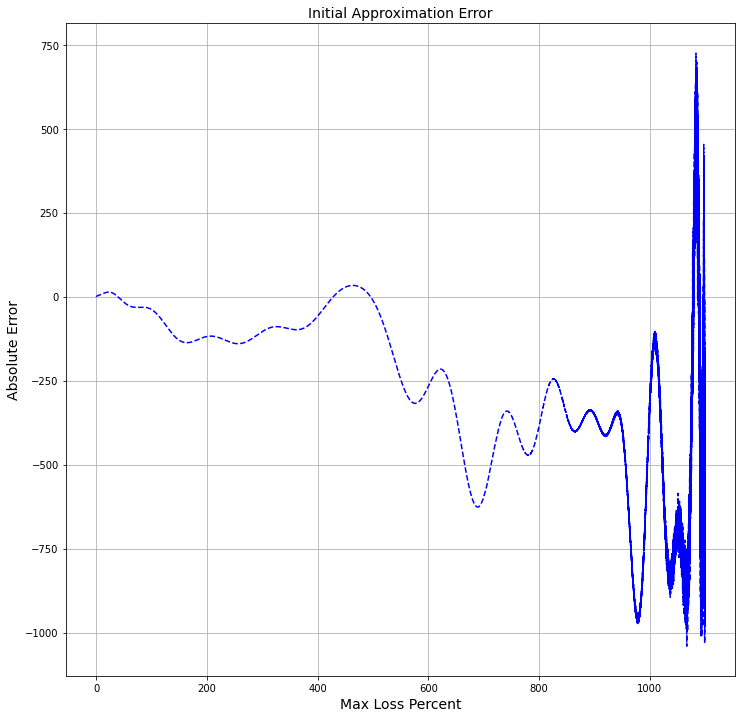

In [368]:
# Plot the absolute error from the initial Chebyshev polynomial
plt.subplots(figsize=(12,12))
plt.grid(True)
plt.title('Initial Approximation Error', fontsize=14)
plt.xlabel('Max Loss Percent', fontsize=14)
plt.ylabel('Absolute Error', fontsize=14)

plt.plot(x_test, y_test - f_approx(x_test), '--', color="blue")

In [369]:
# FIXME: Add a box and whisker plot
error = y_test - f_approx(x_test)

# Calculate the error averages and extrema
print(f"median error = {np.median(error):.20f}")
print(f"average error = {np.average(error):.20f}")
print(f"min error = {np.amin(error):.20f}")
print(f"max error = {np.amax(error):.20f}")

median error = -126.17203449758294198091
average error = -205.76325693982090569989
min error = -1040.57689273073606273101
max error = 725.38158423871129798499


In [370]:
rat = ratfit(x, y, x_test, y_test, 10)

num_degree = 2 & div_degree = 0
error = 7.48685606387057 & min_error = inf
updated best fit
num_degree = 1 & div_degree = 1
error = 27.2396226931753 & min_error = 7.48685606387057
num_degree = 3 & div_degree = 0
error = 4.169127555045875 & min_error = 7.48685606387057
updated best fit
num_degree = 2 & div_degree = 1
error = 3.5617791006646367 & min_error = 4.169127555045875
updated best fit
num_degree = 1 & div_degree = 2
error = 1729.9280611974145 & min_error = 3.5617791006646367
num_degree = 4 & div_degree = 0
error = 2.8343393187371917 & min_error = 3.5617791006646367
updated best fit
num_degree = 3 & div_degree = 1
error = 1.1544401601184988 & min_error = 2.8343393187371917
updated best fit
num_degree = 2 & div_degree = 2
error = 2.1302218711637315 & min_error = 1.1544401601184988
num_degree = 1 & div_degree = 3
error = 99.99900000000025 & min_error = 1.1544401601184988
num_degree = 5 & div_degree = 0
error = 2.1251683730148274 & min_error = 1.1544401601184988
num_degree = 4 & div_

In [371]:
error = y_test - rat(x_test)

# Calculate the error averages and extrema
print(f"median error = {np.median(error):.20f}")
print(f"average error = {np.average(error):.20f}")
print(f"min error = {np.amin(error):.20f}")
print(f"max error = {np.amax(error):.20f}")

median error = -0.00064605094559055942
average error = -0.00016340329606925961
min error = -0.03695884750052291084
max error = 0.04916060217248560682
